# Project- 5

### Import Libraries

In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Load Data

In [67]:
# read data
df=pd.read_csv('./data/2018_gov.csv')
df.head()

,Unnamed: 0,dist,cong,gender,birthyr,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
0,392782,19,115,Female,1964,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
1,392786,52,115,Female,1990,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
2,392800,49,115,Male,1932,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
3,392832,36,115,Male,1938,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
4,392860,36,115,Male,1935,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


In [68]:
df.shape

(3752, 14)

In [69]:
# drop unnamed: 0, birthyr and cong columns 
# (age column and birthyr show the same information, cong has one category so can't be used as a variable)
df=df.drop(columns=['Unnamed: 0', 'birthyr', 'cong'])

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752 entries, 0 to 3751
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3752 non-null   int64 
 1   gender        3752 non-null   object
 2   age           3752 non-null   int64 
 3   educ          3752 non-null   object
 4   race          3752 non-null   object
 5   faminc        3752 non-null   object
 6   marstat       3752 non-null   object
 7   newsint       3752 non-null   object
 8   approval_gov  3752 non-null   object
 9   ideo5         3752 non-null   object
 10  voted_gov     3752 non-null   object
dtypes: int64(2), object(9)
memory usage: 322.6+ KB


In [71]:
# baseline accuracy
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]       0.612207
[Republican / Candidate 2]     0.367537
I Did Not Vote In This Race    0.009861
Not Sure                       0.006663
Other                          0.003731
Name: voted_gov, dtype: float64

Baseline accuracy is 61.2%. We have unimbalanced data.

In [72]:
# drop other categories, make it a binary classification
df = df[(df.voted_gov != 'I Did Not Vote In This Race') & (df.voted_gov != 'Not Sure') & (df.voted_gov != 'Other')]
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]      0.624864
[Republican / Candidate 2]    0.375136
Name: voted_gov, dtype: float64

In [73]:
# transform voted_gov column to categorical dtype and save it to a new column
df['voted_gov_num'] = pd.Categorical(df['voted_gov'], 
                                     categories= ['[Democrat / Candidate 1]', '[Republican / Candidate 2]'])
codes, uniques = pd.factorize(df['voted_gov_num'])
df['voted_gov_num']=codes
df.head()

,dist,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov,voted_gov_num
0,19,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
1,52,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
2,49,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2],1
3,36,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1
4,36,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1


In [74]:
df.to_csv('./data/2018_gov_clean.csv')

## Pre-processing

In [75]:
# set up X and y
X = df.drop(columns =['voted_gov', 'voted_gov_num'])
y = df['voted_gov_num']

In [76]:
X= pd.get_dummies(X, drop_first=True)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

## Modeling

### 1. RandomForest

In [78]:
rf = RandomForestClassifier()

In [79]:
et = ExtraTreesClassifier()

In [80]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.907876982561351

In [81]:
cross_val_score(et, X_train, y_train, cv=5).mean()

0.9064250769352166

Random forest and extremely randomized trees performed pretty much the same, random forest is slightly better.

In [82]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [83]:
# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9089685420447671


{'bootstrap': True,
 'max_depth': None,
 'max_features': 0.5,
 'n_estimators': 200,
 'random_state': 42}

In [84]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_val, y_val))

best score: 0.9089685420447671
best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 0.5, 'n_estimators': 200, 'random_state': 42}
accuracy on train data: 1.0
accuracy on test data: 0.9107725788900979


In [85]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

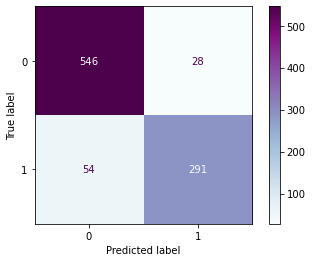

In [86]:
# plot a confusion matrix
plot_confusion_matrix(gs_rf, X_val, y_val, cmap='BuPu', values_format='d');

In [87]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)

print('Accuracy:', accu)
print('Recall:', sens)
print('Precision:', prec)

Accuracy: 0.9107725788900979
Recall: 0.8434782608695652
Precision: 0.9122257053291536


It is overfit.

In [88]:
# get feature importances
pd.Series(gs_rf.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)

approval_gov_Strongly Disapprove                 0.490274
age                                              0.057604
dist                                             0.054508
approval_gov_Strongly Approve                    0.050136
ideo5_Liberal                                    0.048397
ideo5_Very Liberal                               0.034646
approval_gov_Disapprove / Somewhat Disapprove    0.031026
ideo5_Very Conservative                          0.029971
ideo5_Moderate                                   0.018806
race_White                                       0.013361
gender_Male                                      0.009938
race_Black                                       0.009638
ideo5_Not Sure                                   0.008939
newsint_Only now and then                        0.008425
educ_4-Year                                      0.008205
newsint_Most of the time                         0.007893
marstat_Married                                  0.007186
race_Hispanic 

-  For a classfication random forest model, feature_importances_ is based on the average decrease in Gini impurity over the decision trees. 
- Strongly disapprove category of approval_gov feature has a 45.1% importance in the random forest model. For this variable, individuals were asked "Do you approve of the way each is doing their job". 
- approval_gov_Strongly Approve has a 4.7% importance.
- Age has 6.4% and dist has 5.9%. (dist is Congressional district number in current Congress)

In [89]:
# approval_gov column categories
df['approval_gov'].value_counts()

Strongly Disapprove                 1179
Approve / Somewhat Approve          1111
Strongly Approve                     890
Disapprove / Somewhat Disapprove     365
Never Heard / Not Sure               131
Name: approval_gov, dtype: int64

In [95]:
gs_rf.predict(X_val)[:10]

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [93]:
pred = gs_rf.predict_proba(X_val)
pred[:10]

array([[0.   , 1.   ],
       [1.   , 0.   ],
       [0.53 , 0.47 ],
       [0.795, 0.205],
       [0.985, 0.015],
       [0.87 , 0.13 ],
       [0.905, 0.095],
       [0.   , 1.   ],
       [0.98 , 0.02 ],
       [0.99 , 0.01 ]])

- The first array, [0, 1], corresponds to the first testing observation. - This first testing observation is predicted to have a 0% chance that  𝑌=0 and a 100% chance that  𝑌=1. The `.predict()` value for this observation is 1. This is because  𝑃(𝑌=1)>𝑃(𝑌=0).
- The fourth array, [0.795, 0.205], corresponds to the fourth testing observation. - This fourth testing observation is predicted to have a 79.5% chance that  𝑌=0 and a 20.5% chance that  𝑌=1. The `.predict()` value for this observation is 0. This is because  𝑃(𝑌=0)>𝑃(𝑌=1).